In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:2px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:10pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:11pt;padding:4px;}
table.dataframe{font-size:10px;}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd
import sys
from tensorflow.keras.utils import to_categorical  # 원핫인코딩
from tensorflow.keras.models import Sequential,save_model, load_model 
from tensorflow.keras.layers import Input, Dense, Dropout
from matplotlib import pyplot as plt # 학습 과정 그래프
from sklearn.metrics import confusion_matrix # 혼동행렬
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split  # 데이터 분리

# 이진분류
```
1. 데이터 셋 생성 & 전처리
 엑셀 -> 데이터프레임 -> ?처리(df.replace('?',np.nan) -> 결측치 처리
 -> X, y 분리 -> X변수 스케일 조정 -> train_test_split함수로 학습셋과 테스트셋 분리
2. 모델 생성(입력13, 출력 1) & 학습과정 설정 & 학습
3. 모델 평가(그래프, 평가, 교차표)
4. 모델 사용(저장, 예측)
```



### 컬럼명   의미 및 설명

- cp   흉통의 유형 (Chest Pain type)
    - 0: 전형적 협심증 / 1: 비전형적 협심증 / 2: 비심장성 흉통 / 3: 무증상
- treshtbps   안정 시 수축기 혈압 (Resting Blood Pressure in mm Hg)
- chol   혈청 콜레스테롤 수치 (Serum Cholesterol in mg/dl)
- fbs   공복혈당 120mg/dl 이상 여부 (Fasting Blood Sugar) - 1: Yes, 0: No
- restecg   안정 시 심전도 결과 (Resting Electrocardiographic Results)
    - 0: 정상 / 1: ST-T 이상 / 2: 좌심실 비대 가능성
- thalach   최대 심박수 (Maximum Heart Rate Achieved)
- exang   운동 중 협심증 여부 (Exercise Induced Angina) - 1: 있음, 0: 없음
- oldpeak   운동 후 ST 감소 정도 (ST Depression induced by exercise relative to rest)
- slope   ST segment의 기울기 (Slope of the peak exercise ST segment)
    - 1: 수평  / 2: 상승  / 3: 하강
- ca   형광투시검사에서 관찰된 주요 혈관 수 (Number of major vessels colored by fluoroscopy)
- hsl (일반적으로 thal로 표기됨)   지혈소 상태 (Thalassemia)
    - 3: 정상 / 6: 고정결함 / 7: 가역적 결함
- heartDisease   심장병 여부 (Target Variable)
    - 1: 심장병 있음 / 0: 없음

## 1. 데이터 셋 생성 & 전처리
 엑셀 -> 데이터프레임 -> ?처리(df.replace('?',np.nan) -> 결측치 처리
 -> X, y 분리 -> X변수 스케일조정 -> train_test_split함수로 학습셋과 테스트셋분리

In [17]:
dataset = pd.read_excel('data/heart-disease.xlsx')
dataset.info()  
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [19]:
dataset.isin(['?']).any() # 물음표가 있는 열

age             False
sex             False
cp              False
treshtbps       False
chol             True
fbs             False
restecg         False
thalach         False
exang           False
oldpeak         False
slope           False
ca               True
hsl              True
heartDisease    False
dtype: bool

In [20]:
# '?'가 포함된 데이터 추출 ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
dataset[(dataset['chol']=='?') | (dataset['ca']=='?') | (dataset['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [4]:
dataset['chol'] = dataset['chol'].replace('?', np.nan)
mean_chol = dataset['chol'].mean()
dataset['chol'] = dataset['chol'].fillna(mean_chol)

dataset['ca'] = dataset['ca'].replace('?', np.nan)
mean_ca = dataset['ca'].mean()
dataset['ca'] = dataset['ca'].fillna(mean_ca)

dataset['hsl'] = dataset['hsl'].replace('?', np.nan)
mean_hsl = dataset['hsl'].mean()
dataset['hsl'] = dataset['hsl'].fillna(mean_hsl)
dataset

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.000000,1,2,150,0,2.3,3,0.000000,6.0,0
1,67,1,4,160,286.000000,0,0,108,1,1.5,2,3.000000,3.0,1
2,67,1,4,120,246.751656,0,2,129,1,2.6,2,2.000000,7.0,1
3,37,1,3,130,250.000000,0,0,187,0,3.5,3,0.000000,3.0,0
4,41,0,2,130,204.000000,0,2,172,0,1.4,1,0.000000,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264.000000,0,0,132,0,1.2,2,0.000000,7.0,1
299,68,1,4,144,193.000000,1,0,141,0,3.4,2,2.000000,7.0,1
300,57,1,4,130,131.000000,0,0,115,1,1.2,2,1.000000,7.0,1
301,57,0,2,130,236.000000,0,2,174,0,0.0,2,1.000000,3.0,1


In [21]:
# '?'를 결측치(np.nan)로 대체  ■■■■■■■■■■■■■■■■■■■■■■■■■■■
df = dataset.replace('?', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [22]:
# ■결측치 처리 : 대체 or 제거 ■■■■■■■■■■■■■■■■■■■■■■■
df.fillna(value=df.median(), inplace=True) # 결측치를 중위수로 대체
# df = df.dropna(how='any')  #결측치 제거
df.isna().sum() # 결측치가 없는지 확인

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [ ]:
# Target변수의 분포(0:음성, 1:양성) ■■■■■■■■■■■■■■■■■■■■■■■
print(df['heartDisease'].value_counts()) 
# negative, positive = df['heartDisease'].value_counts()
# total = df.shape[0]
# print('음성 결과 :', negative/total)
# print('양성 결과 :', positive/total)
print(df['heartDisease'].value_counts(normalize=True)) 

In [25]:
# 입력변수와 타겟변수 분리 ■■■■■■■■■■■■■■■■■■■■■■■ 추천 안함
X = df.iloc[:, :-1].values
y = df.iloc[:, -1:].values
X.shape, y.shape

((303, 13), (303, 1))

In [5]:
X_data = dataset.drop('heartDisease', axis=1)
y = dataset['heartDisease']

X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X_data)

In [26]:
# 입력변수 X의 스케일 조정 ■■■■■■■■■■■■■■■■■■■■■■■ 
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X

array([[0.70833333, 1.        , 0.        , ..., 1.        , 0.        ,
        0.75      ],
       [0.79166667, 1.        , 1.        , ..., 0.5       , 1.        ,
        0.        ],
       [0.79166667, 1.        , 1.        , ..., 0.5       , 0.66666667,
        1.        ],
       ...,
       [0.58333333, 1.        , 1.        , ..., 0.5       , 0.33333333,
        1.        ],
       [0.58333333, 0.        , 0.33333333, ..., 0.5       , 0.33333333,
        0.        ],
       [0.1875    , 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ]])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, )
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((242, 13), (242,), (61, 13), (61,))

In [43]:
#scaled_X, y를 학습셋:테스트셋=7:3으로 분할  ■■■■■■■■■■■■■■■■■■■■■■■
X_train, X_test, y_train, y_test = train_test_split(scaled_X, 
                                                    y,
                                                   test_size=0.3, # 테스트셋 비율
                                                   random_state=7,
                                                   stratify=y # stratify 층화추출
                                                   ) 
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((212, 13), (212, 1), (91, 13), (91, 1))

In [44]:
# 음성|양성 비율   ■■■■■■■■■■■■■■■■■■■■■■■
print(pd.DataFrame(y).value_counts(normalize=True))  # 전체 데이터
print(pd.DataFrame(y_train).value_counts(normalize=True)) # y_train
print(pd.DataFrame(y_test).value_counts(normalize=True))  # y_test

0    0.541254
1    0.458746
dtype: float64
0    0.542453
1    0.457547
dtype: float64
0    0.538462
1    0.461538
dtype: float64


## 2. 모델 생성(입력13, 출력1) & 학습과정 설정 & 학습
- 그래프를 보고 과적합 줄이기 추가할 수 있음

In [79]:
#  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
model = Sequential()
# model.add(Input(shape=(13,)))
model.add(Dense(units=32, 
                input_dim=13,
                activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1,  activation='sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 32)                448       
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_39 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_40 (Dense)            (None, 8)                 136       
                                                                 
 dropout_12 (Dropout)        (None, 8)                 0         
                                                                 
 dense_41 (Dense)            (None, 1)                

In [80]:
#  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
             #optimizer=Adam(learning_rate=0.01),
              optimizer='adam',
             metrics=['accuracy', # 정확도
                      metrics.Recall(), # 재현율(실제값 중심)
                      metrics.Precision()]) # 정밀도(예측값 중심)

In [81]:
%%time
#  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
hist = model.fit(X_train,y_train, # 훈련데이터
                epochs=150,
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=1)

Epoch 1/150
6/6 [==============================] - 1s 55ms/step - loss: 0.7219 - accuracy: 0.5207 - recall_5: 0.1974 - precision_5: 0.4286 - val_loss: 0.7372 - val_accuracy: 0.5116 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 2/150
6/6 [==============================] - 0s 9ms/step - loss: 0.7110 - accuracy: 0.5917 - recall_5: 0.2368 - precision_5: 0.6207 - val_loss: 0.7260 - val_accuracy: 0.5349 - val_recall_5: 0.0476 - val_precision_5: 1.0000
Epoch 3/150
6/6 [==============================] - 0s 9ms/step - loss: 0.7095 - accuracy: 0.4852 - recall_5: 0.1711 - precision_5: 0.3514 - val_loss: 0.7152 - val_accuracy: 0.5349 - val_recall_5: 0.0476 - val_precision_5: 1.0000
Epoch 4/150
6/6 [==============================] - 0s 9ms/step - loss: 0.7050 - accuracy: 0.5621 - recall_5: 0.3158 - precision_5: 0.5217 - val_loss: 0.7050 - val_accuracy: 0.5581 - val_recall_5: 0.0952 - val_precision_5: 1.0000
Epoch 5/150
6/6 [==============================] - 0s 9ms/step - loss: 0.72

Epoch 37/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4904 - accuracy: 0.7574 - recall_5: 0.6447 - precision_5: 0.7778 - val_loss: 0.4887 - val_accuracy: 0.8605 - val_recall_5: 0.8571 - val_precision_5: 0.8571
Epoch 38/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5146 - accuracy: 0.7574 - recall_5: 0.6316 - precision_5: 0.7869 - val_loss: 0.4858 - val_accuracy: 0.8605 - val_recall_5: 0.8571 - val_precision_5: 0.8571
Epoch 39/150
6/6 [==============================] - 0s 7ms/step - loss: 0.5140 - accuracy: 0.7751 - recall_5: 0.7105 - precision_5: 0.7714 - val_loss: 0.4819 - val_accuracy: 0.8605 - val_recall_5: 0.8571 - val_precision_5: 0.8571
Epoch 40/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5264 - accuracy: 0.7337 - recall_5: 0.6184 - precision_5: 0.7460 - val_loss: 0.4802 - val_accuracy: 0.8605 - val_recall_5: 0.8571 - val_precision_5: 0.8571
Epoch 41/150
6/6 [==============================] - 0s 10ms/step - loss: 0.4699 

Epoch 73/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4258 - accuracy: 0.7929 - recall_5: 0.7237 - precision_5: 0.7971 - val_loss: 0.4772 - val_accuracy: 0.7907 - val_recall_5: 0.8095 - val_precision_5: 0.7727
Epoch 74/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4353 - accuracy: 0.8166 - recall_5: 0.7632 - precision_5: 0.8169 - val_loss: 0.4801 - val_accuracy: 0.7907 - val_recall_5: 0.8095 - val_precision_5: 0.7727
Epoch 75/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4141 - accuracy: 0.8166 - recall_5: 0.7237 - precision_5: 0.8462 - val_loss: 0.4827 - val_accuracy: 0.7907 - val_recall_5: 0.8095 - val_precision_5: 0.7727
Epoch 76/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4213 - accuracy: 0.8107 - recall_5: 0.7500 - precision_5: 0.8143 - val_loss: 0.4863 - val_accuracy: 0.7907 - val_recall_5: 0.8095 - val_precision_5: 0.7727
Epoch 77/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4328 -

6/6 [==============================] - 0s 8ms/step - loss: 0.3933 - accuracy: 0.8284 - recall_5: 0.7368 - precision_5: 0.8615 - val_loss: 0.5486 - val_accuracy: 0.7674 - val_recall_5: 0.7619 - val_precision_5: 0.7619
Epoch 144/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3689 - accuracy: 0.8225 - recall_5: 0.7632 - precision_5: 0.8286 - val_loss: 0.5471 - val_accuracy: 0.7674 - val_recall_5: 0.7619 - val_precision_5: 0.7619
Epoch 145/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3678 - accuracy: 0.8639 - recall_5: 0.7763 - precision_5: 0.9077 - val_loss: 0.5449 - val_accuracy: 0.7442 - val_recall_5: 0.7143 - val_precision_5: 0.7500
Epoch 146/150
6/6 [==============================] - 0s 8ms/step - loss: 0.4151 - accuracy: 0.8225 - recall_5: 0.7368 - precision_5: 0.8485 - val_loss: 0.5455 - val_accuracy: 0.7442 - val_recall_5: 0.7143 - val_precision_5: 0.7500
Epoch 147/150
6/6 [==============================] - 0s 7ms/step - loss: 0.4125 - accuracy

## 3. 모델 평가(그래프, 평가, 교차표)

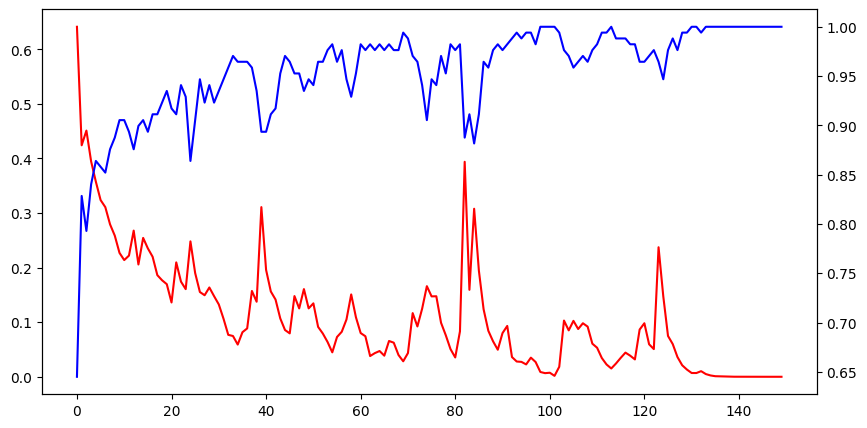

In [53]:
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r')
acc_ax = loss_ax.twinx() 
acc_ax.plot(hist.history.get('accuracy'), 'b')

In [82]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall_5', 'precision_5', 'val_loss', 'val_accuracy', 'val_recall_5', 'val_precision_5'])

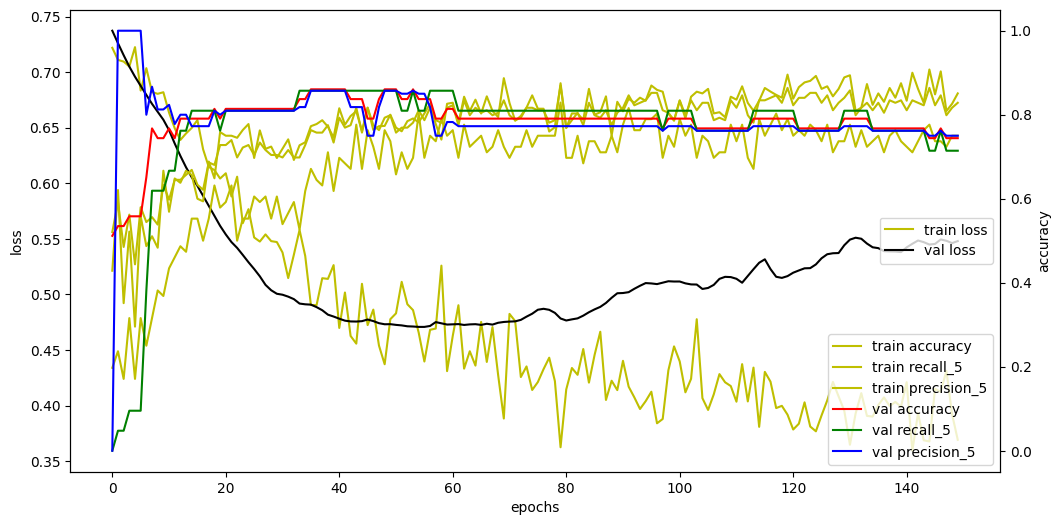

In [83]:
#  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'k', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'y', label='train accuracy')
acc_ax.plot(hist.history['recall_5'], 'y', label='train recall_5')
acc_ax.plot(hist.history['precision_5'], 'y', label='train precision_5')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='val accuracy')
acc_ax.plot(hist.history['val_recall_5'], 'g', label='val recall_5')
acc_ax.plot(hist.history['val_precision_5'], 'b', label='val precision_5')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [84]:
#  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
score = model.evaluate(X_test, y_test, verbose=0)
print('model loss : ', score[0])
print('model accuracy : ', score[1])
print('model recall : ', score[2])
print('model precision : ', score[3])

model loss :  0.3510476052761078
model accuracy :  0.8461538553237915
model recall :  0.8571428656578064
model precision :  0.8181818127632141


In [85]:
#  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
y_test.reshape(-1) # 실제값

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0], dtype=int64)

In [11]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 1.7296 - binary_accuracy: 0.7541


[1.7295868396759033, 0.7540983557701111]

In [89]:
#  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
y_hat = (model.predict(X_test)>0.5).astype(int).reshape(-1)
pd.crosstab(y_test.reshape(-1), y_hat, 
           rownames=['실제값'], colnames=['예측값'])

3/3 [==============================] - 0s 2ms/step


예측값,0,1
실제값,,
0,41,8
1,6,36


In [12]:
y_hat = (model.predict(X_test)>=0.5).astype(float)

2/2 [==============================] - 0s 2ms/step


## 4. 모델 사용(저장, 예측)

In [90]:
#  ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
model.save('model/07heaer.h5')
save_model(model, 'model/07heaer.h5')

In [91]:
model2 = load_model('model/07heaer.h5')

# 분류분석
```
1. 데이터 셋 생성 & 전처리
 엑셀 -> 데이터프레임 -> ?처리(df.replace('?',np.nan) -> 결측치 처리
 -> X, y 분리 -> X변수 스케일 조정 -> train_test_split함수로 학습셋과 테스트셋 분리
 -> y 변수들의 원핫인코딩
2. 모델 생성(입력13, 출력 2) & 학습과정 설정 & 학습
3. 모델 평가(그래프, 평가, 교차표)
4. 모델 사용(저장, 예측)
```

## 1. 데이터 셋 생성 & 전처리
    - 위와동일+원핫인코딩     

In [92]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((212, 2), (91, 2))

## 2. 모델 생성(입력13, 출력2) & 학습과정 설정 & 학습

In [94]:
model = Sequential()
# model.add(Input(shape=(13,)))
model.add(Dense(units=32, 
                input_dim=13,
                activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
#model.add(Dense(units=1,  activation='sigmoid'))
model.add(Dense(units=2,  activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 32)                448       
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_43 (Dense)            (None, 16)                528       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_44 (Dense)            (None, 8)                 136       
                                                                 
 dropout_15 (Dropout)        (None, 8)                 0         
                                                                 
 dense_45 (Dense)            (None, 2)                

In [97]:
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam',
             metrics=['accuracy', # 정확도
                      metrics.Recall(), # 재현율(실제값 중심)
                      metrics.Precision()]) # 정밀도(예측값 중심)

In [98]:
%%time
hist = model.fit(X_train, Y_train, # 훈련데이터
                epochs=200,
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0)

CPU times: total: 9.72 s
Wall time: 8.18 s


## 3. 모델 평가(그래프, 평가, 교차표)

In [99]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall_7', 'precision_6', 'val_loss', 'val_accuracy', 'val_recall_7', 'val_precision_6'])

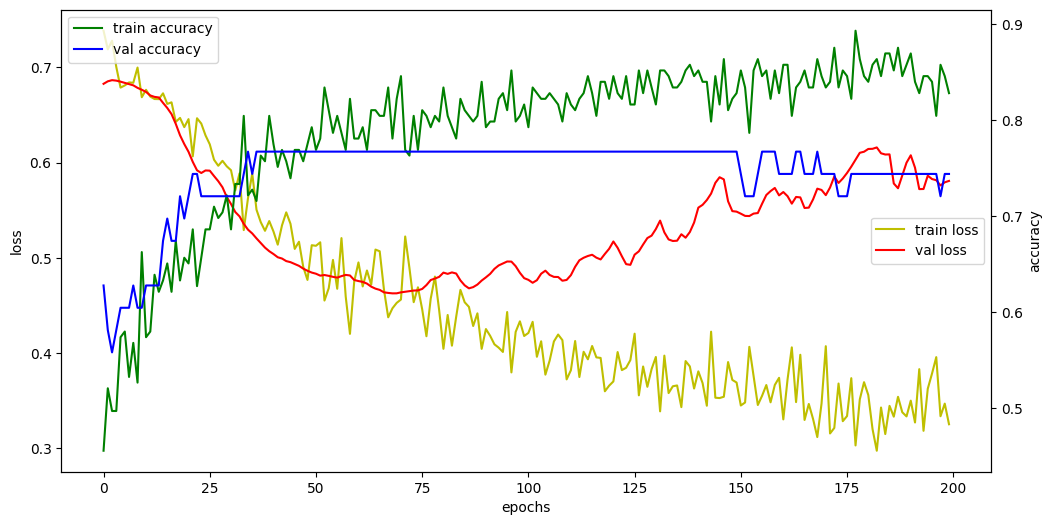

In [100]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [102]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('model loss : ', score[0])
print('model accuracy : ', score[1])
print('model recall : ', score[2])
print('model precision : ', score[3])

model loss :  0.3661916255950928
model accuracy :  0.8681318759918213
model recall :  0.8681318759918213
model precision :  0.8681318759918213


In [103]:
# 교차표
y_hat = model.predict(X_test).argmax(axis=1)
y_hat

3/3 [==============================] - 0s 2ms/step


array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0], dtype=int64)

In [104]:
pd.crosstab(y_test.reshape(-1), y_hat,
           rownames=['실제값'],
           colnames=['예측값'])

예측값,0,1
실제값,,
0,43,6
1,6,36


## 4. 모델 사용(저장, 예측)